In [1]:
import json, pickle
import glob

import numpy as np
import pandas as pd
import builtins

from qiskit import transpile
from qiskit import execute, QuantumRegister, ClassicalRegister, Aer
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder, construct_mbl_circ_with_cut
from gnn import ExpValCircuitGraphModel

/home/sreyas/.conda/envs/mlqem/lib/python3.9/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/sreyas/.conda/envs/mlqem/lib/python3.9/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.32' not found (required by /home/sreyas/.conda/envs/mlqem/lib/python3.9/site-packages/torch_sparse/_version_cpu.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
backend = FakeMontreal()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(backend) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

In [3]:
def generating_func(circ_cut):
    num_spins = 8 # Number of spins. Must be even.
    W = 0.8 * np.pi # Disorder strength up to np.pi
    theta = 0.05 * np.pi # Interaction strength up to np.pi
    steps = 6

    disorders = generate_disorder(num_spins, W)
    qc = construct_mbl_circ_with_cut(num_spins, disorders, theta, steps, broken_connections=circ_cut)
    qc_trans = transpile(qc, backend=backend_noisy, optimization_level=3)
    
    #print the size of the circuit
    # print('Size of the circuit: ', qc.num_qubits, 'qubits and ', qc.size(), 'gates', qc.num_ancillas, 'ancillas', qc.num_clbits, 'clbits')
    # print('Size of the transpiled circuit: ', qc_trans.num_qubits, 'qubits and ', qc_trans.size(), 'gates', qc_trans.num_ancillas, 'ancillas', qc_trans.num_clbits, 'clbits')    

    return qc_trans, qc, disorders

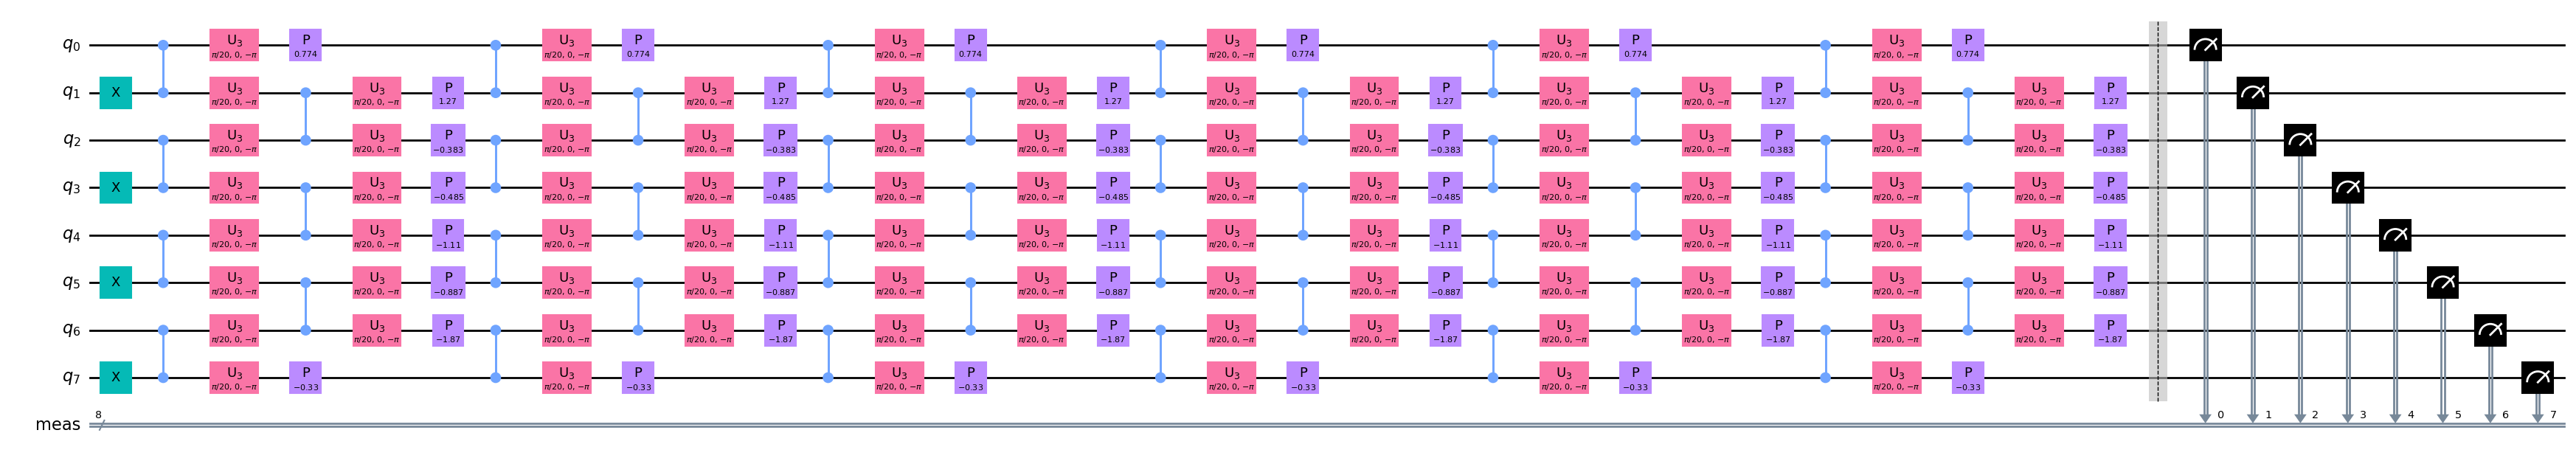

In [4]:
generating_func([])[1].draw('mpl', fold=-1, idle_wires=False)

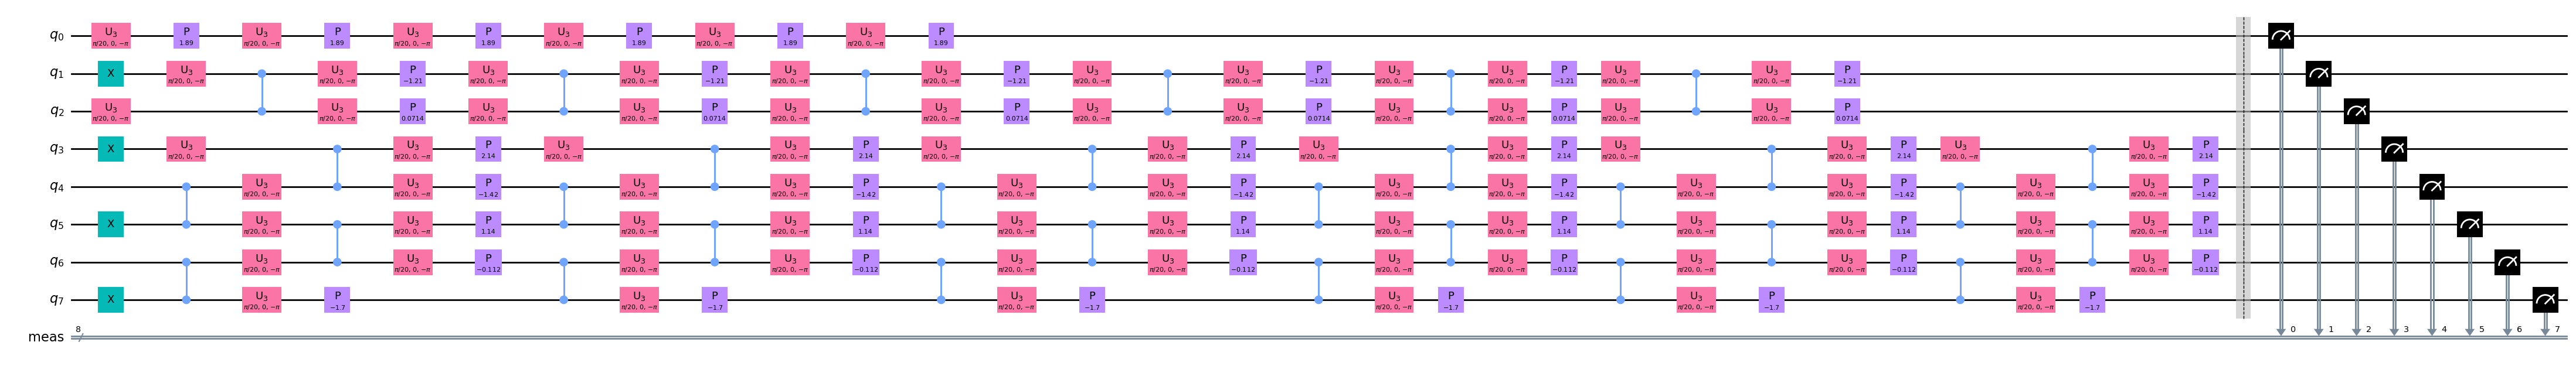

In [5]:
generating_func([(0, 1), (2, 3)])[1].draw('mpl', fold=-1, idle_wires=False)

# Circuit Cut Data Generation

In [6]:
from qiskit.transpiler.exceptions import TranspilerError
from scipy.linalg import LinAlgError

def generate_data(circ_cut, save_path: str, n_entries_per_file: int):
    entries = []

    for i in tqdm_notebook(range(n_entries_per_file)):
        success = False
        while not success:
            try:
                circuit, _, disorders = generating_func(circ_cut)
                # print(disorders)
                success = True
                # print the number of qubits in the circuit
                print(f"Number of qubits in the circuit: {circuit.num_qubits}")

            except (LinAlgError, TranspilerError, np.linalg.LinAlgError) as e:
                print(f"Ran into an error:, {e}")

        job_ideal = execute(circuit, **run_config_ideal)
        job_noisy = execute(circuit, **run_config_noisy)

        counts_ideal = job_ideal.result().get_counts()
        counts_noisy = job_noisy.result().get_counts()

        ideal_exp_val = cal_z_exp(counts_ideal)
        noisy_exp_val = cal_z_exp(counts_noisy)

        graph_data = circuit_to_graph_data_json(
            circuit=circuit,
            properties=properties,
            use_qubit_features=True,
            use_gate_features=True,
        )

        
        entry = ExpValueEntry(
            circuit_graph=graph_data,
            observable=[],
            ideal_exp_value=ideal_exp_val.tolist(),
            noisy_exp_values=[noisy_exp_val.tolist()],
            circuit_depth=circuit.depth()
        )
        to_append = entry.to_dict()
        to_append['circuit'] = circuit
        entries.append(to_append)

    path = f"{save_path}/step6_q0-q7_total8.pk"
    f = builtins.open(path, "wb")
    pickle.dump(entries, f)
    f.close()

In [7]:
circ_cut = []
total_num_qubits = 8
generate_data(circ_cut, './data/s_test/val', 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Number of qubits in the circuit: 27
Number of qubits in the circuit: 27
Number of qubits in the circuit: 27
Number of qubits in the circuit: 27
Number of qubits in the circuit: 27
Number of qubits in the circuit: 27
Number of qubits in the circuit: 27
Number of qubits in the circuit: 27
Number of qubits in the circuit: 27
Number of qubits in the circuit: 27
